In [1]:
import kagglehub

import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from pathlib import Path
import numpy as np

import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# machine optimizations
print(tf.config.list_physical_devices("GPU"))
mixed_precision.set_global_policy('mixed_float16') # uses less precise float16 instead of float32 for all layers apart from the last one. remember to change it in the last layer, otherwise the model will not be able to predict

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1. Load Dataset from Kaggle

##### Dataset Description: Mushroom Image Classification
The dataset utilized in this project is sourced from Kaggle: Mushrooms Dataset by derekkunowilliams.​

##### Dataset Structure
The dataset is organized into a hierarchical folder structure:​

```markdown
mushroom_dataset/
└── [edibility class]/
    └── [species]/
        └── [images]
```

Each subfolder contains multiple images in .png format, representing individual mushroom species.​

##### Data Preprocessing
To prepare the dataset for deep learning:

- The species-level folders were flattened into their respective edibility class labels.​
- All images were resized to 224×224 pixels to match MobileNetV2 input requirements.​
- TensorFlow’s `image_dataset_from_directory()` function was used to load and split the dataset into training and validation subsets.​

##### Disclaimer on Safety
The dataset contains a warning that there may be label inaccuracies due to the use of web-sourced images.
It should not be used for real-life decisions about mushroom edibility, as misclassification may lead to dangerous outcomes.​

In [3]:
# Download latest version of dataset from kaggle url(https://www.kaggle.com/datasets/derekkunowilliams/mushrooms)
path = kagglehub.dataset_download("derekkunowilliams/mushrooms")
source_root = Path(os.path.join(path, "mushroom_dataset"))
print("Path to dataset files:", source_root)

Path to dataset files: /Users/mikolajkahl/.cache/kagglehub/datasets/derekkunowilliams/mushrooms/versions/1/mushroom_dataset


In [4]:
# Root path of the dataset
root_dir = "mushroom_dataset_4class"

dest_root = Path(root_dir)
if not dest_root.exists():
    dest_root.mkdir(exist_ok=True)

    # Define the top-level labels
    labels = ["edible", "deadly", "poisonous", "conditionally_edible"]

    # Create destination folders and flatten species into category
    for label in labels:
        src_label_path = source_root / label
        dst_label_path = dest_root / label
        dst_label_path.mkdir(parents=True, exist_ok=True)

        for species_dir in src_label_path.iterdir():
            if species_dir.is_dir():
                for img_file in species_dir.glob("*.*"):  # Match .png, .jpg, etc.
                    # Generate a unique filename to avoid overwriting
                    dest_file = dst_label_path / f"{species_dir.name}_{img_file.name}"
                    shutil.copy(img_file, dest_file)

    print("Dataset flattened to 4-class format at:", dest_root.resolve())
else:
    print("Directory 'mushroom_dataset_4class' already exists. Skipping operation.")


Directory 'mushroom_dataset_4class' already exists. Skipping operation.


### 2. Basic Exploratory Data Analysis

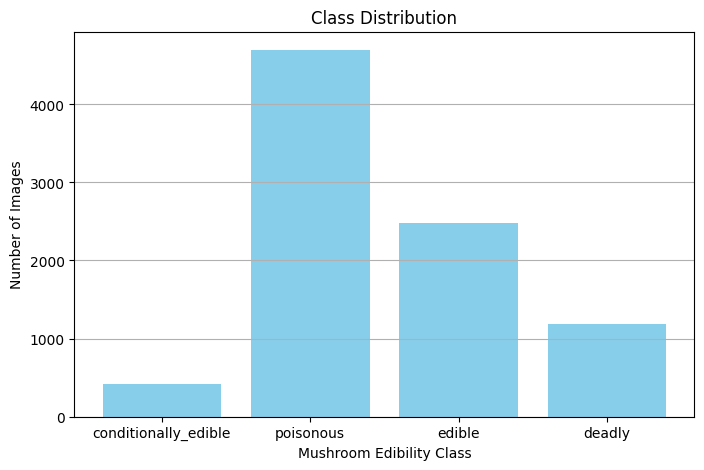

In [5]:
# Count number of images per class
class_counts = {}
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len([
            f for f in os.listdir(class_path) 
            if os.path.isfile(os.path.join(class_path, f))
        ])

# Plot
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Mushroom Edibility Class")
plt.grid(True, axis='y')
plt.show()


In [6]:
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
print(df.sort_values("Count", ascending=False))

                  Class  Count
1             poisonous   4696
2                edible   2475
3                deadly   1190
0  conditionally_edible    420


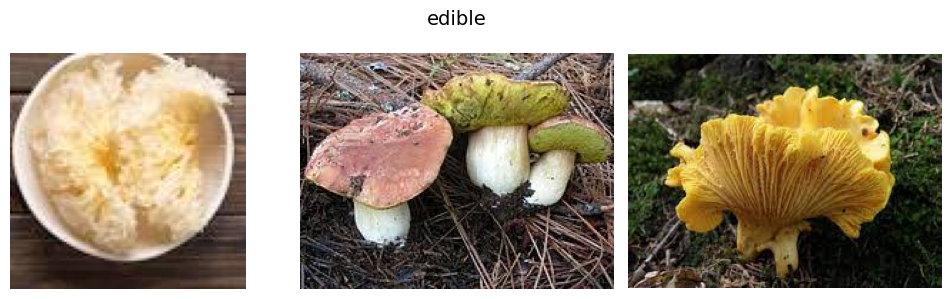

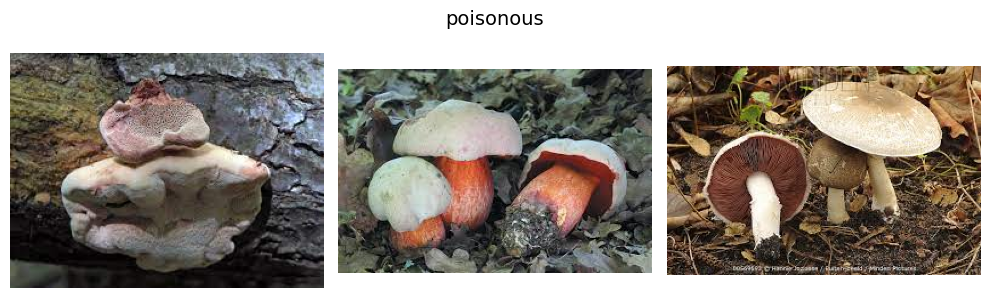

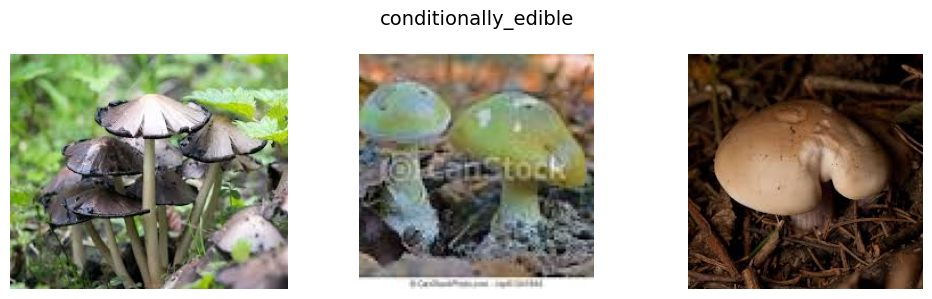

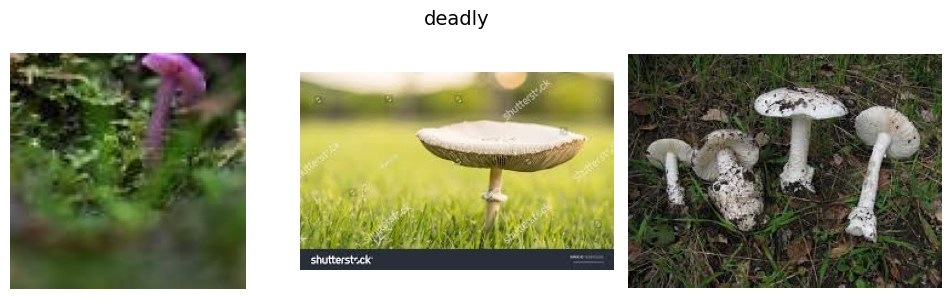

In [7]:
# Root directory with your 4 classes
data_dir = "mushroom_dataset_4class"
class_names = ["edible", "poisonous", "conditionally_edible", "deadly"]

def show_3_random_images_per_class():
    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)
        all_images = os.listdir(class_path)
        sample_imgs = random.sample(all_images, min(3, len(all_images)))

        plt.figure(figsize=(10, 3))
        for i, img_name in enumerate(sample_imgs):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"{class_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

show_3_random_images_per_class()


### 3. Train-Test split

##### Train/Validation Split and Dataset Optimization

To evaluate the model's performance fairly and prevent overfitting, I split the dataset into **80% training** and **20% validation** subsets using TensorFlow's `image_dataset_from_directory()` method. A 20% validation split is a commonly accepted practice in machine learning that provides a reliable estimation of the model’s generalization ability while still leaving enough data for training.

I ensured the split was **reproducible** by setting a fixed random seed (`seed=SEED`). All images were resized to `(224, 224)` pixels to match the input size required by MobileNetV2, and batched into groups of 32 for efficient processing during training.

To further optimize data loading and speed up training, I applied two key TensorFlow pipeline enhancements:
- **Caching**: stores the preprocessed dataset in memory after the first epoch, reducing disk I/O during subsequent epochs.
- **Prefetching**: overlaps data preprocessing with model training using `AUTOTUNE`, allowing data to be prepared while the model is training on the previous batch.

These optimizations help improve training throughput and for better utilization of CPU/GPU resources.


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 8781 files belonging to 4 classes.
Using 7025 files for training.


2025-04-22 21:57:30.392147: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-04-22 21:57:30.392173: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-22 21:57:30.392180: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1745351850.392194 17865490 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745351850.392216 17865490 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 8781 files belonging to 4 classes.
Using 1756 files for validation.


In [9]:
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Label dtype: {labels.dtype}")


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


2025-04-22 21:57:30.717113: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-22 21:57:30.717808: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Data Augmentation Strategy

To improve the model's ability to generalize to new, unseen data, data augmentation was applied to the training images. Augmentation helps simulate natural variations in images, such as orientation, scale, lighting, and positioning, which are especially relevant when working with real-world images like mushrooms taken from various angles and environments.

Augmentation was implemented using TensorFlow’s built-in preprocessing layers, applied directly within the model pipeline to ensure that transformations are performed dynamically during training without altering the original dataset.

Several augmentation strategies were used across experiments:
- **Horizontal flipping** reflects natural variations in mushroom orientation.
- **Zoom and rotation** simulate changes in camera distance and viewing angle.
- **Brightness and contrast adjustments** mimic different lighting conditions found in nature.
- **Translation** accounts for positional shifts of mushrooms in the frame.

These techniques were chosen because they mirror realistic conditions under which mushroom photos might be taken, making them particularly well-suited to this image classification task.


In [10]:
def get_augmentation(name):
    if name == "flip":
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal")
        ])
    elif name == "flip_zoom":
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomZoom(0.1)
        ])
    elif name == "flip_rotate":
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.15)
        ])
    elif name == "full_augmentation":
        # Full augmentation with various techniques
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.15),
            layers.RandomZoom(0.1),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
            layers.RandomTranslation(0.1, 0.1),
        ])
    else:  # default / none
        return tf.keras.Sequential([])


### 4. The Chosen Base Model: MobileNetV2

For this project, I used **MobileNetV2** as the foundational model for transfer learning. MobileNetV2 is a convolutional neural network (CNN) architecture designed to deliver high accuracy while maintaining computational efficiency, making it particularly suitable for deployment on devices with limited resources like e.g. smartphones.

#### Understanding CNNs and MobileNetV2

Convolutional Neural Networks (CNNs) are a class of deep learning models specifically tailored for processing data with a grid-like topology, such as images. They utilize convolutional layers to automatically and adaptively learn spatial hierarchies of features from input data.

MobileNetV2 builds upon traditional CNNs by introducing architectural innovations aimed at reducing model size and computational cost without significantly compromising accuracy.

#### Model Complexity

MobileNetV2 is known for its lightweight nature. For instance, a standard MobileNetV2 model trained on ImageNet has approximately **3.4 million parameters** and a model size of around **13.3 MB** :contentReference[oaicite:1]{index=1}. This compactness facilitates faster training and inference times, which is advantageous when experimenting with multiple configurations or deploying models on devices with limited computational capabilities.

#### Suitability for the Project

The choice of MobileNetV2 aligns well with the objectives of this project:

- **Transfer Learning**: Utilizing a model pre-trained on a large dataset like ImageNet allows us to leverage learned features, accelerating convergence and improving performance on our specific task of mushroom classification.

- **Efficiency**: Its lightweight architecture ensures that training and inference are computationally manageable, even on machines without high-end GPUs.

- **Flexibility**: MobileNetV2's modular design allows for easy customization, such as replacing the top classification layers, enabling experimentation with different classifier architectures tailored to our dataset.

In summary, MobileNetV2 offers a robust and efficient foundation for image classification tasks, making it an apt choice for this project's exploration into deep learning methodologies.


In [11]:
BASE_MODEL =MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

In [12]:
BASE_MODEL.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### 5. Model Training Testing Framework

To evaluate different training configurations and understand their effect on model performance, a modular and reusable experimentation framework was developed. This system allowed for structured experimentation with a wide range of variables including model fine-tuning depth, learning rate, data augmentation strategy, classifier architecture, and training duration.

Each experiment is represented as a dictionary specifying all relevant parameters. These dictionaries are stored in a list and passed to a loop that automatically runs each configuration and stores the results. Key variables that were systematically tested include:

- Whether or not to fine-tune the base model, and if so, how many layers to unfreeze
- Different learning rates (e.g., `1e-6`, `1e-5`, `1e-4`)
- Varying training durations (5, 10, or 15 epochs)
- Multiple augmentation strategies
- Three classifier head architectures

By varying one factor at a time while keeping others constant, this framework enabled a controlled analysis of each component’s impact on model performance. Results (including validation accuracy and loss) were collected in a structured format to support visual and tabular comparisons across all configurations. The best performing model in the experiment section is later fine-tuned further to maximize the results of prediction.


In [13]:
def get_classifier(name):
    if name == "simple":
        return [
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')
        ]
    elif name == "deep":
        return [
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')
        ]
    elif name == "minimal":
        return [
            layers.GlobalAveragePooling2D(),
            layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')
        ]
    else:
        raise ValueError("Unknown classifier head")


In [14]:
def build_model(fine_tune, fine_tune_at, augmentation_name, classifier_name):
    base_model = BASE_MODEL

    if fine_tune:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    data_aug = get_augmentation(augmentation_name)
    classifier_head = get_classifier(classifier_name)

    model = models.Sequential([
        layers.InputLayer(input_shape=(*IMG_SIZE, 3)),
        data_aug,
        base_model,
        *classifier_head
    ])
    return model


In [15]:
def train_model(model, learning_rate=1e-5, epochs=200):
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop]
    )
    return model, history


In [16]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [17]:
def plot_confusion_matrix(model):
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()


In [18]:
def run_experiment(name, fine_tune, fine_tune_at, learning_rate, augmentation_name, classifier_name):
    print(f"\nRunning: {name} ({'fine-tuned' if fine_tune else 'frozen'})")
    model = build_model(
        fine_tune=fine_tune,
        fine_tune_at=fine_tune_at,
        augmentation_name=augmentation_name,
        classifier_name=classifier_name
    )

    model, history = train_model(
        model,
        learning_rate=learning_rate,
    )

    plot_history(history)
    plot_confusion_matrix(model)

    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    best_epoch = len(history.history['val_loss'])

    print(f"{name} done | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f} | Epochs Run: {best_epoch}")

    return {
        "name": name,
        "fine_tune": fine_tune,
        "fine_tune_at": fine_tune_at,
        "learning_rate": learning_rate,
        "augmentation": augmentation_name,
        "classifier": classifier_name,
        "val_accuracy": val_acc,
        "val_loss": val_loss,
        "epochs_ran": best_epoch,
        "history": history
    }

### 6. Training Experiments

In [19]:
experiments = [
    # Baseline (frozen)
    {
        "name": "ft_last_0_flip_simple",
        "fine_tune": False,
        "fine_tune_at": None,
        "learning_rate": 1e-3,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    # fine-tuning influence experiment
    {
        "name": "ft_last_30_flip_simple",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_last_50_flip_simple",
        "fine_tune": True,
        "fine_tune_at": -50,
        "learning_rate": 1e-5,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_last_80_flip_simple",
        "fine_tune": True,
        "fine_tune_at": -80,
        "learning_rate": 1e-5,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_all_layers_flip_simple",
        "fine_tune": True,
        "fine_tune_at": 0,
        "learning_rate": 1e-5,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    # testing different augmentations

    {
        "name": "ft_last_30_flip_zoom_simple",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "augmentation_name": "flip_zoom",
        "classifier_name": "simple"
    },

        {
        "name": "ft_last_30_flip_rotate_simple",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "augmentation_name": "flip_rotate",
        "classifier_name": "simple"
    },

    # testing different classifiers

    {
        "name": "ft_last_30_flip_deep",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "augmentation_name": "flip",
        "classifier_name": "deep"
    },

    {
        "name": "ft_last_30_flip_minimal",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "augmentation_name": "flip",
        "classifier_name": "minimal"
    },

    # testing different learning rates

    {
        "name": "ft_last_30_flip_simple_lr_1e-4",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-4,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_last_30_flip_simple_lr_1e-6",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-6,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    }
]



Running: ft_last_0_flip_simple (frozen)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-04-22 21:57:32.084992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


220/220 ━━━━━━━━━━━━━━━━━━━━ 35s 147ms/step - accuracy: 0.4026 - loss: 2.3471 - val_accuracy: 0.5438 - val_loss: 1.1389
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - accuracy: 0.4294 - loss: 1.8706 - val_accuracy: 0.5564 - val_loss: 1.1172
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.4573 - loss: 1.4815 - val_accuracy: 0.5575 - val_loss: 1.0741
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - accuracy: 0.4823 - loss: 1.2998 - val_accuracy: 0.5541 - val_loss: 1.0702
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.5131 - loss: 1.1869 - val_accuracy: 0.5524 - val_loss: 1.0610
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - accuracy: 0.5452 - loss: 1.1420 - val_accuracy: 0.5524 - val_loss: 1.0512
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.5495 - loss: 1.1099 - val_accuracy: 0.5604 - val_loss: 1.0477
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.5514 - loss: 1.094

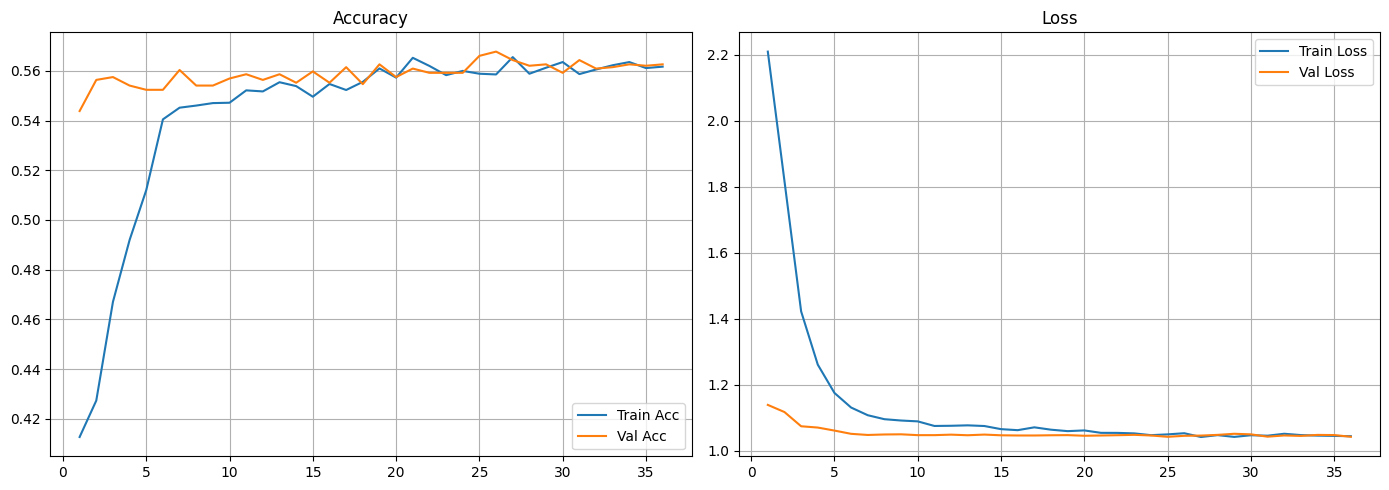

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-04-22 23:05:46.053896: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


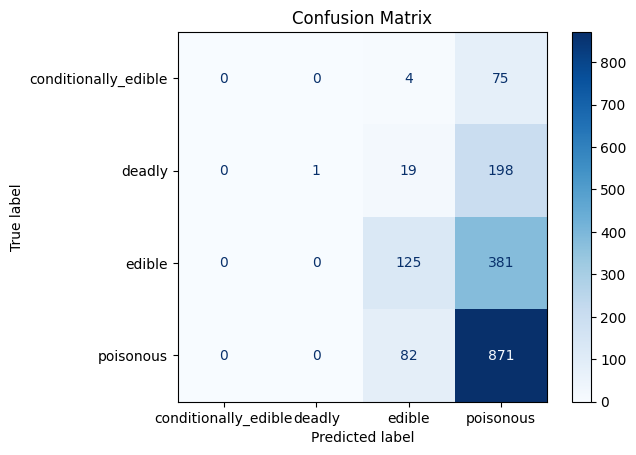

ft_last_0_flip_simple done | Val Acc: 0.5626 | Val Loss: 1.0422 | Epochs Run: 36

Running: ft_last_30_flip_simple (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 314ms/step - accuracy: 0.4079 - loss: 1.5418 - val_accuracy: 0.2306 - val_loss: 1.5746
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.4646 - loss: 1.3105 - val_accuracy: 0.3320 - val_loss: 1.4203
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 292ms/step - accuracy: 0.5017 - loss: 1.2260 - val_accuracy: 0.4305 - val_loss: 1.3129
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 67s 303ms/step - accuracy: 0.5152 - loss: 1.1793 - val_accuracy: 0.4801 - val_loss: 1.2448
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 301ms/step - accuracy: 0.5291 - loss: 1.1446 - val_accuracy: 0.5296 - val_loss: 1.2107
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 67s 304ms/step - accuracy: 0.5293 - loss: 1.1284 - val_accuracy: 0.5353 - val_loss: 1.1777
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.5345 - loss: 1.1061 - val_accuracy: 0.5347 - val_loss: 1.1617
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 313ms/step - accuracy: 0.5583 - loss: 1.073

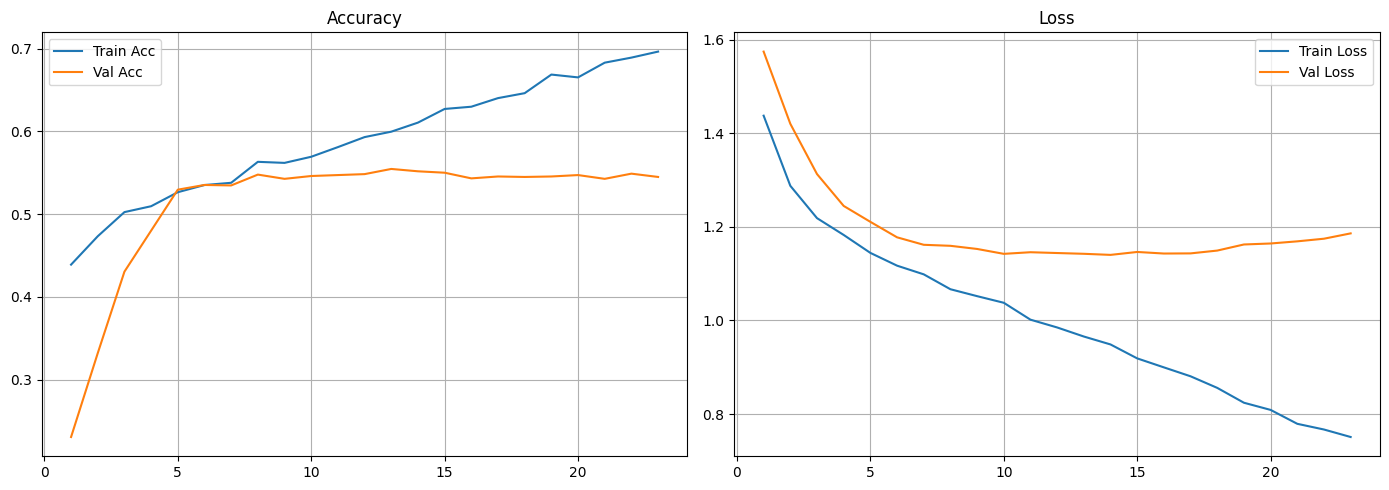

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

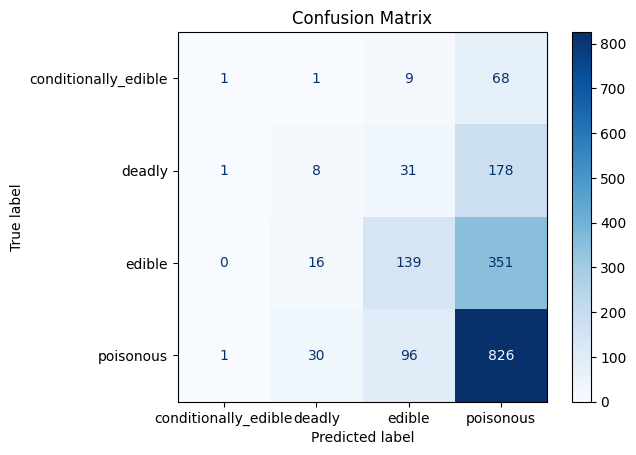

ft_last_30_flip_simple done | Val Acc: 0.5450 | Val Loss: 1.1861 | Epochs Run: 23

Running: ft_last_50_flip_simple (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 93s 383ms/step - accuracy: 0.3242 - loss: 1.5857 - val_accuracy: 0.3901 - val_loss: 1.2954
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 77s 350ms/step - accuracy: 0.5020 - loss: 1.1909 - val_accuracy: 0.4630 - val_loss: 1.1957
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 78s 353ms/step - accuracy: 0.5387 - loss: 1.1245 - val_accuracy: 0.5114 - val_loss: 1.1479
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 78s 354ms/step - accuracy: 0.5425 - loss: 1.1144 - val_accuracy: 0.5268 - val_loss: 1.1290
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 377ms/step - accuracy: 0.5588 - loss: 1.0739 - val_accuracy: 0.5382 - val_loss: 1.1192
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 85s 387ms/step - accuracy: 0.5675 - loss: 1.0393 - val_accuracy: 0.5461 - val_loss: 1.1143
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 395ms/step - accuracy: 0.5879 - loss: 1.0178 - val_accuracy: 0.5433 - val_loss: 1.1130
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 89s 404ms/step - accuracy: 0.5842 - loss: 0.990

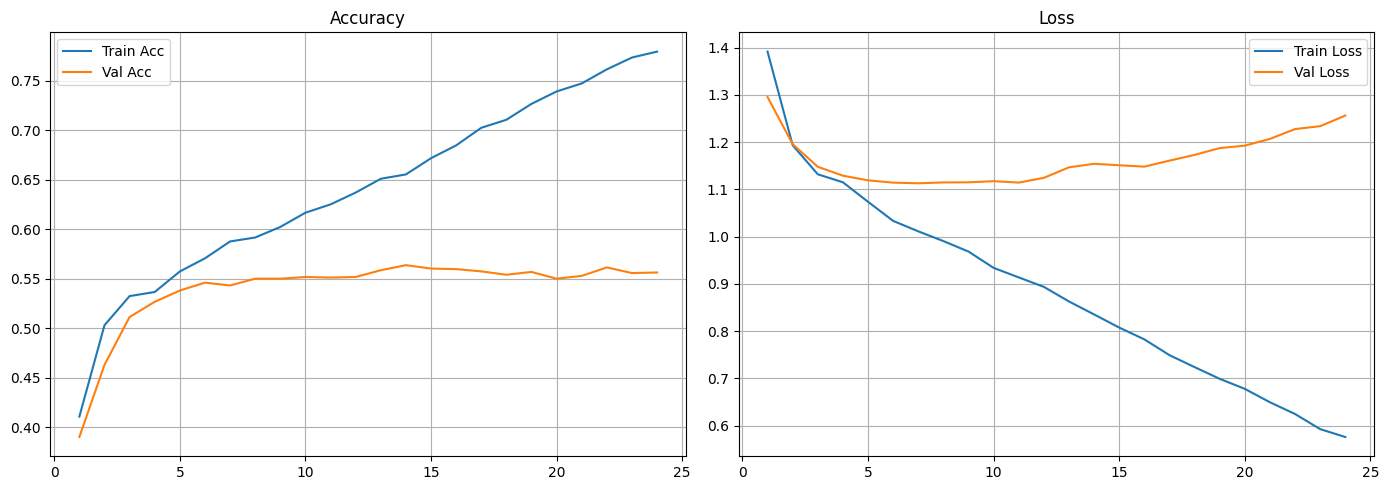

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-04-23 00:36:27.999962: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


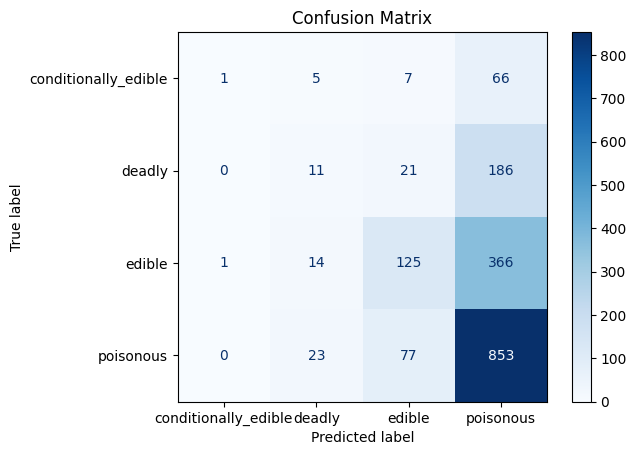

ft_last_50_flip_simple done | Val Acc: 0.5564 | Val Loss: 1.2562 | Epochs Run: 24

Running: ft_last_80_flip_simple (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.4273 - loss: 1.3829 - val_accuracy: 0.5364 - val_loss: 1.1816
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.5305 - loss: 1.1723 - val_accuracy: 0.5513 - val_loss: 1.1581
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - accuracy: 0.5586 - loss: 1.0777 - val_accuracy: 0.5564 - val_loss: 1.1542
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 281ms/step - accuracy: 0.5911 - loss: 1.0277 - val_accuracy: 0.5581 - val_loss: 1.1599
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.6023 - loss: 0.9832 - val_accuracy: 0.5649 - val_loss: 1.1561
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accuracy: 0.6162 - loss: 0.9476 - val_accuracy: 0.5700 - val_loss: 1.1559
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1099s 5s/step - accuracy: 0.6286 - loss: 0.9036 - val_accuracy: 0.5689 - val_loss: 1.1616
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - accuracy: 0.6425 - loss: 0.8813 - v

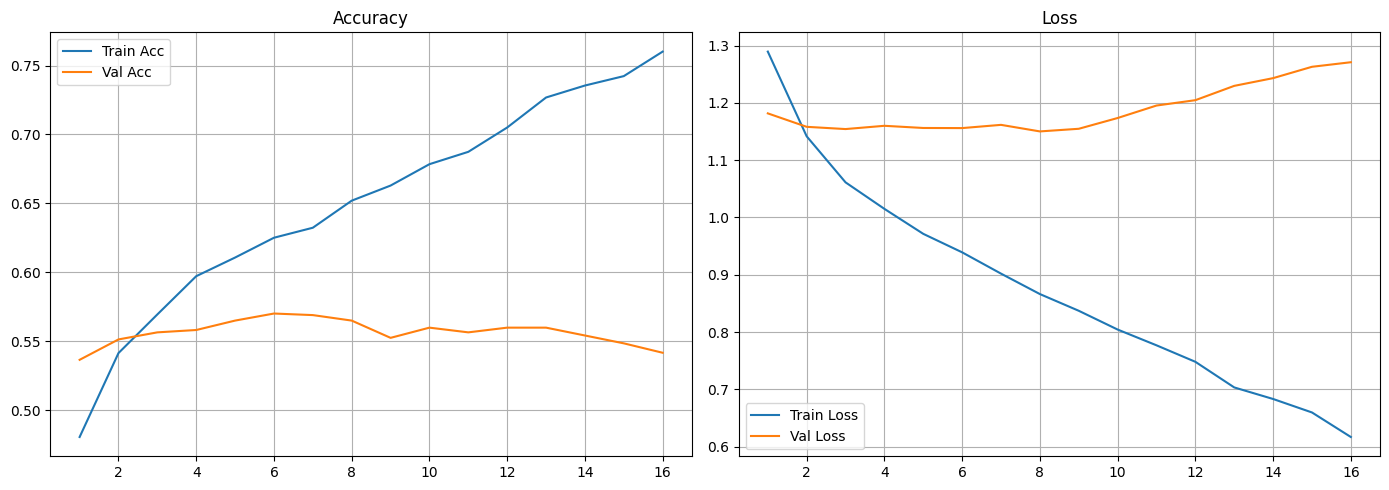

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

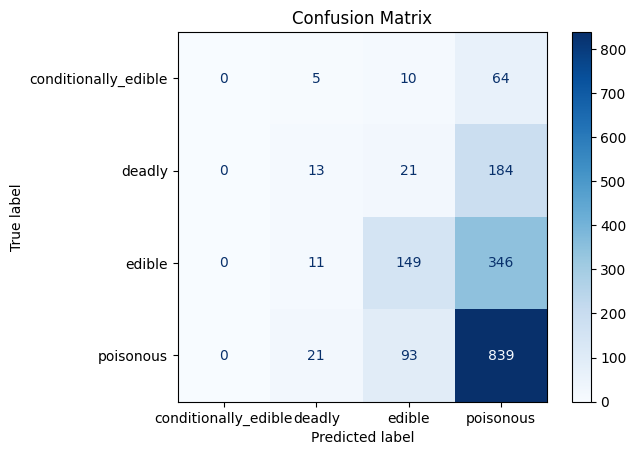

ft_last_80_flip_simple done | Val Acc: 0.5416 | Val Loss: 1.2709 | Epochs Run: 16

Running: ft_all_layers_flip_simple (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 1082s 5s/step - accuracy: 0.3831 - loss: 1.4706 - val_accuracy: 0.4994 - val_loss: 1.1985
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 951s 4s/step - accuracy: 0.5406 - loss: 1.1289 - val_accuracy: 0.5382 - val_loss: 1.1394
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1062s 5s/step - accuracy: 0.5702 - loss: 1.0496 - val_accuracy: 0.5535 - val_loss: 1.1274
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 170ms/step - accuracy: 0.6000 - loss: 0.9853 - val_accuracy: 0.5661 - val_loss: 1.1302
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1027s 5s/step - accuracy: 0.6267 - loss: 0.9382 - val_accuracy: 0.5752 - val_loss: 1.1339
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 961s 4s/step - accuracy: 0.6503 - loss: 0.8918 - val_accuracy: 0.5729 - val_loss: 1.1410
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accuracy: 0.6629 - loss: 0.8428 - val_accuracy: 0.5746 - val_loss: 1.1537
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6788 - loss: 0.8148 - val_a

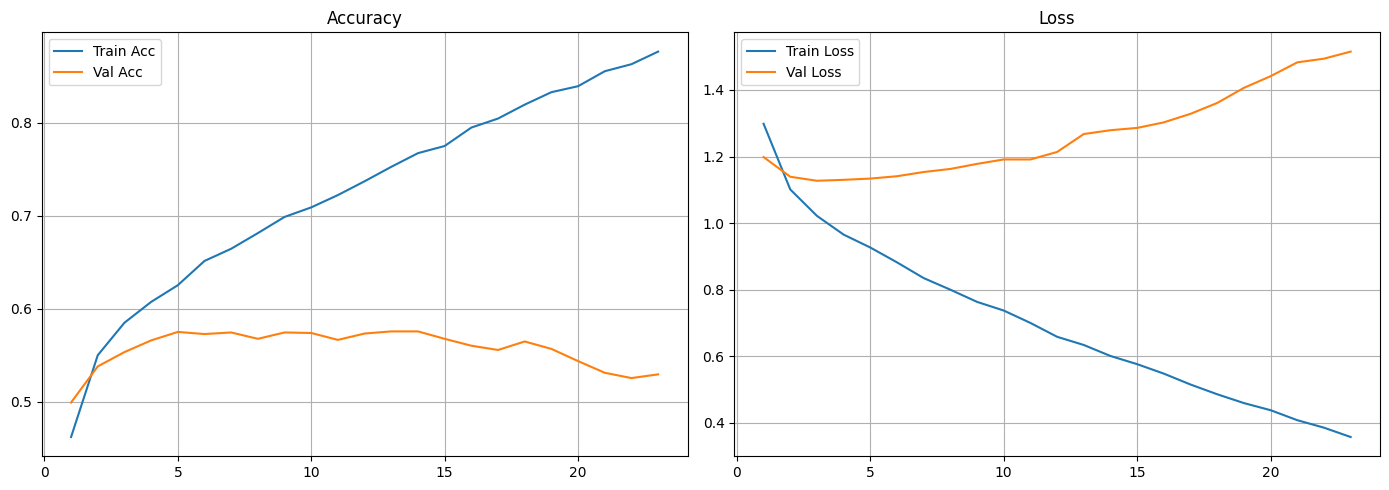

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

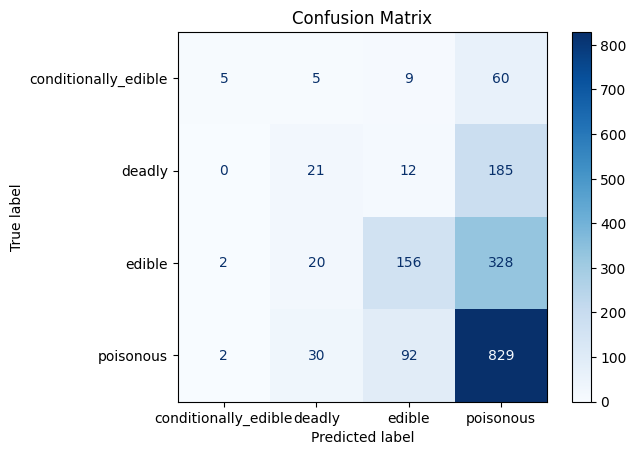

ft_all_layers_flip_simple done | Val Acc: 0.5296 | Val Loss: 1.5153 | Epochs Run: 23

Running: ft_last_30_flip_zoom_simple (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 93s 379ms/step - accuracy: 0.4832 - loss: 1.2671 - val_accuracy: 0.5393 - val_loss: 1.1279
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 75s 342ms/step - accuracy: 0.5322 - loss: 1.1398 - val_accuracy: 0.5575 - val_loss: 1.1198
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.5574 - loss: 1.0904 - val_accuracy: 0.5632 - val_loss: 1.1276
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 323ms/step - accuracy: 0.5768 - loss: 1.0592 - val_accuracy: 0.5678 - val_loss: 1.1228
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 323ms/step - accuracy: 0.5827 - loss: 1.0221 - val_accuracy: 0.5666 - val_loss: 1.1230
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 74s 335ms/step - accuracy: 0.5884 - loss: 1.0144 - val_accuracy: 0.5672 - val_loss: 1.1187
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 78s 356ms/step - accuracy: 0.5940 - loss: 0.9940 - val_accuracy: 0.5706 - val_loss: 1.1226
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 329ms/step - accuracy: 0.6009 - loss: 0.981

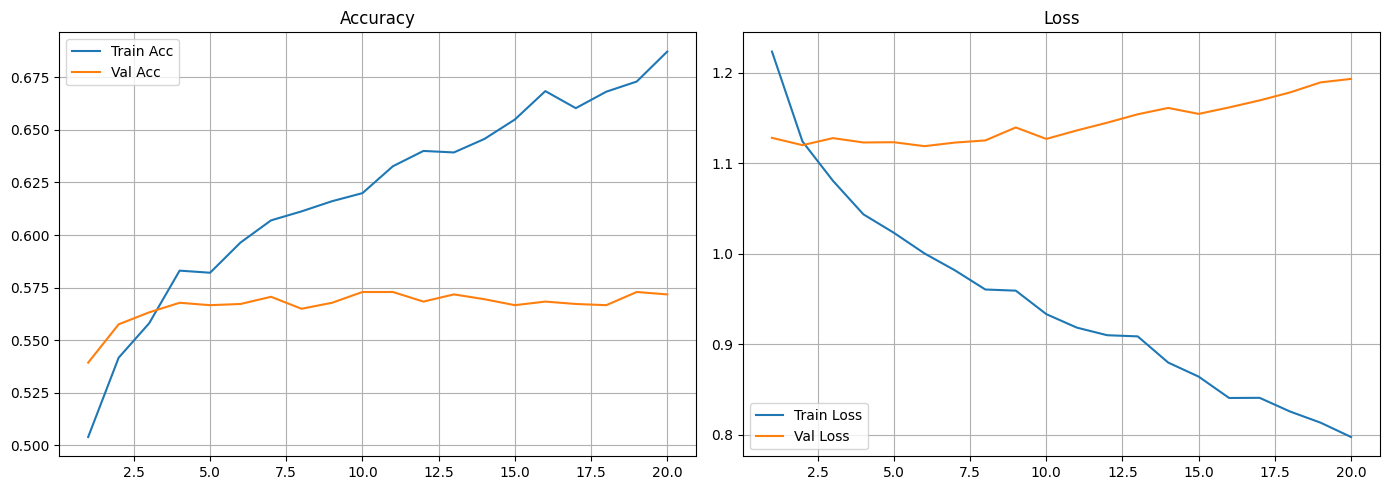

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

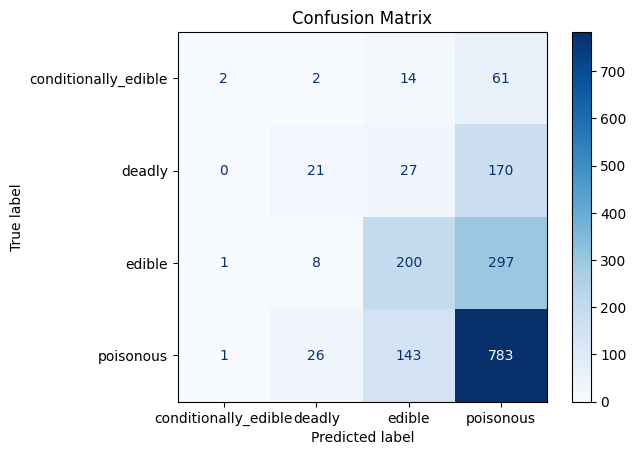

ft_last_30_flip_zoom_simple done | Val Acc: 0.5718 | Val Loss: 1.1929 | Epochs Run: 20

Running: ft_last_30_flip_rotate_simple (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 96s 395ms/step - accuracy: 0.4494 - loss: 1.3081 - val_accuracy: 0.4863 - val_loss: 1.1537
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 344ms/step - accuracy: 0.5159 - loss: 1.1648 - val_accuracy: 0.5194 - val_loss: 1.1167
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 345ms/step - accuracy: 0.5257 - loss: 1.1392 - val_accuracy: 0.5427 - val_loss: 1.0963
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 374ms/step - accuracy: 0.5362 - loss: 1.1203 - val_accuracy: 0.5518 - val_loss: 1.0953
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 377ms/step - accuracy: 0.5544 - loss: 1.1250 - val_accuracy: 0.5587 - val_loss: 1.0915
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 84s 383ms/step - accuracy: 0.5483 - loss: 1.1063 - val_accuracy: 0.5592 - val_loss: 1.0946
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 88s 399ms/step - accuracy: 0.5541 - loss: 1.0859 - val_accuracy: 0.5695 - val_loss: 1.0945
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 84s 382ms/step - accuracy: 0.5509 - loss: 1.117

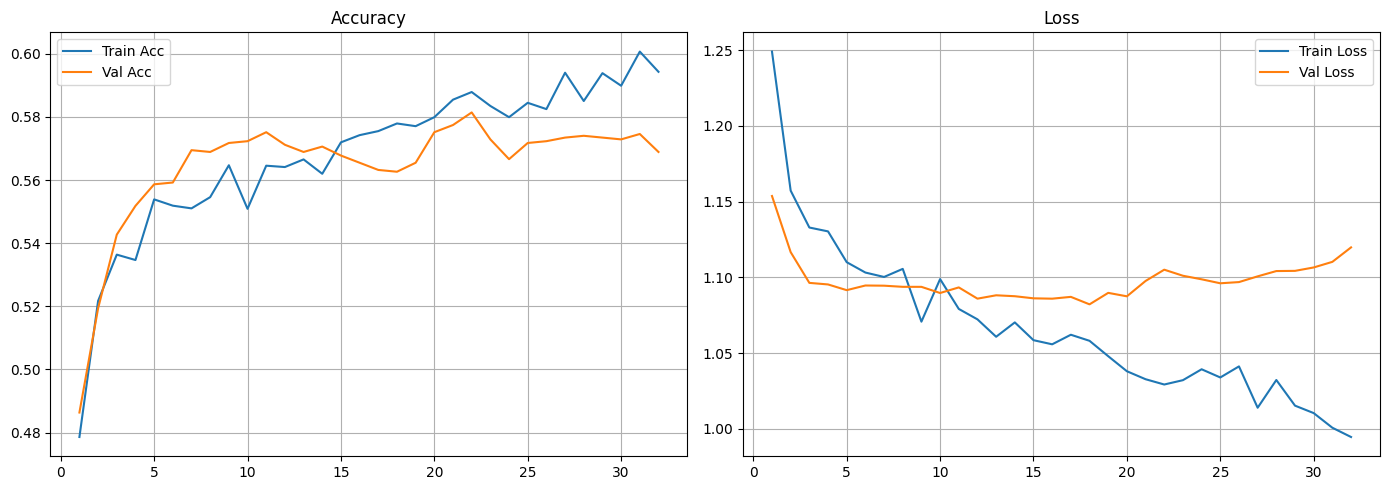

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-04-23 07:10:08.886187: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


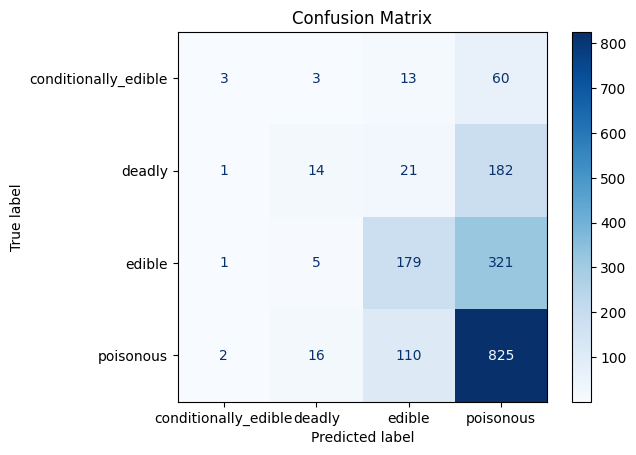

ft_last_30_flip_rotate_simple done | Val Acc: 0.5689 | Val Loss: 1.1198 | Epochs Run: 32

Running: ft_last_30_flip_deep (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 1092s 5s/step - accuracy: 0.3556 - loss: 2.1807 - val_accuracy: 0.5467 - val_loss: 1.1600
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 136s 619ms/step - accuracy: 0.4896 - loss: 1.6345 - val_accuracy: 0.5644 - val_loss: 1.1785
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1005s 5s/step - accuracy: 0.5172 - loss: 1.5568 - val_accuracy: 0.5655 - val_loss: 1.2022
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.5551 - loss: 1.4190 - val_accuracy: 0.5712 - val_loss: 1.2334
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 46s 211ms/step - accuracy: 0.5651 - loss: 1.3954 - val_accuracy: 0.5763 - val_loss: 1.2773
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 112s 512ms/step - accuracy: 0.5815 - loss: 1.3410 - val_accuracy: 0.5706 - val_loss: 1.2945
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.5968 - loss: 1.2876 - val_accuracy: 0.5678 - val_loss: 1.3324
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 173s 790ms/step - accuracy: 0.6027 - loss: 1.2642

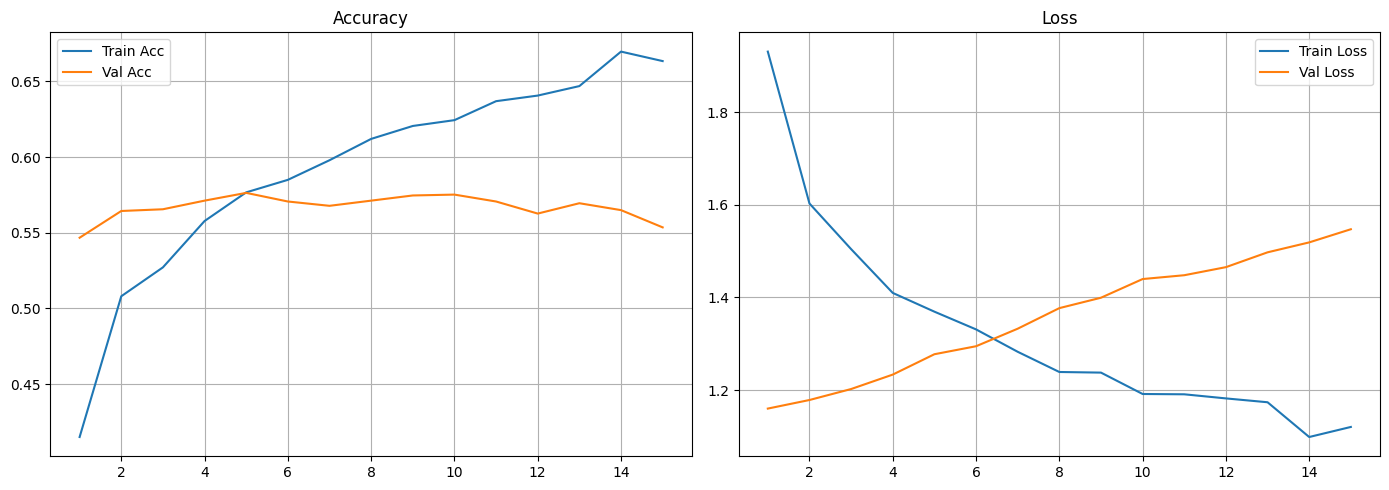

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

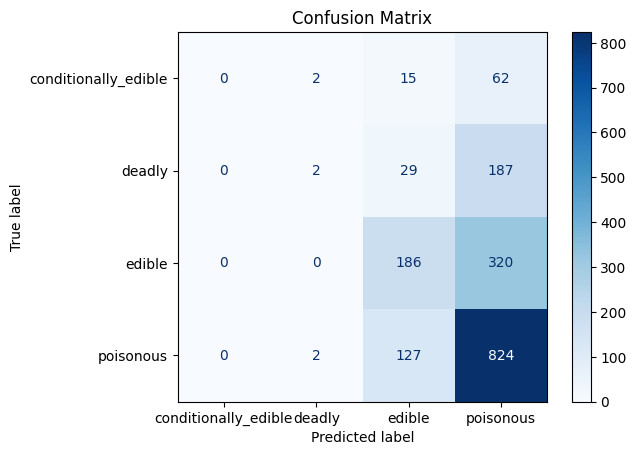

ft_last_30_flip_deep done | Val Acc: 0.5535 | Val Loss: 1.5470 | Epochs Run: 15

Running: ft_last_30_flip_minimal (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 110s 467ms/step - accuracy: 0.4811 - loss: 1.1750 - val_accuracy: 0.1754 - val_loss: 1.5917
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accuracy: 0.6955 - loss: 0.8044 - val_accuracy: 0.3935 - val_loss: 1.3189
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 48s 218ms/step - accuracy: 0.7325 - loss: 0.7142 - val_accuracy: 0.4920 - val_loss: 1.2078
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 57s 257ms/step - accuracy: 0.7527 - loss: 0.6491 - val_accuracy: 0.5262 - val_loss: 1.1679
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 301ms/step - accuracy: 0.7826 - loss: 0.5863 - val_accuracy: 0.5427 - val_loss: 1.1590
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 292ms/step - accuracy: 0.8007 - loss: 0.5466 - val_accuracy: 0.5513 - val_loss: 1.1714
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.8146 - loss: 0.4990 - val_accuracy: 0.5547 - val_loss: 1.1896
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.8274 - loss: 0.46

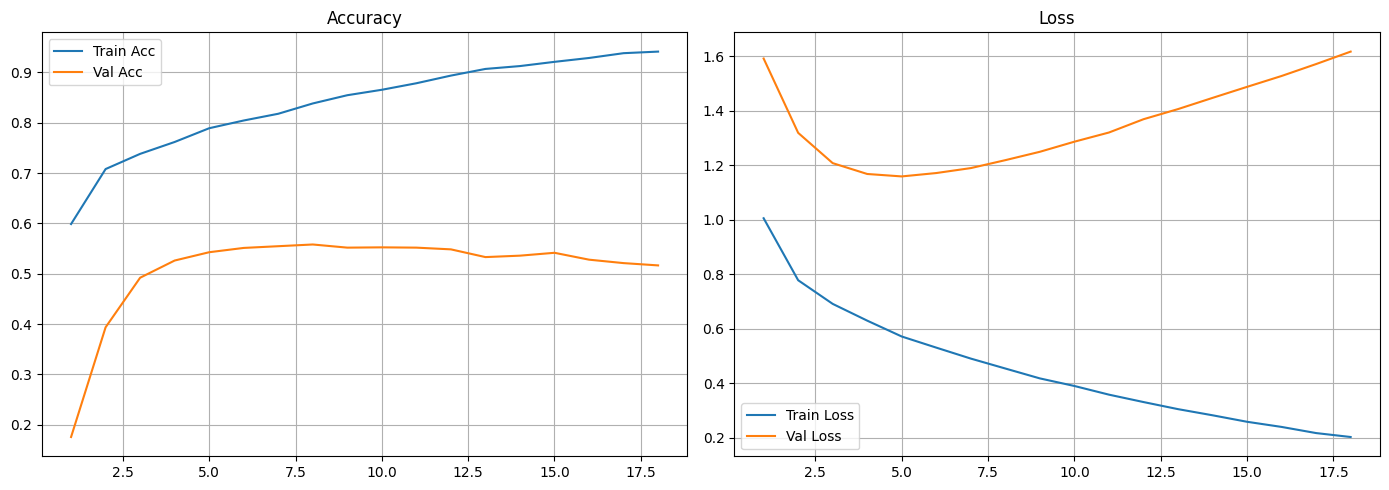

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

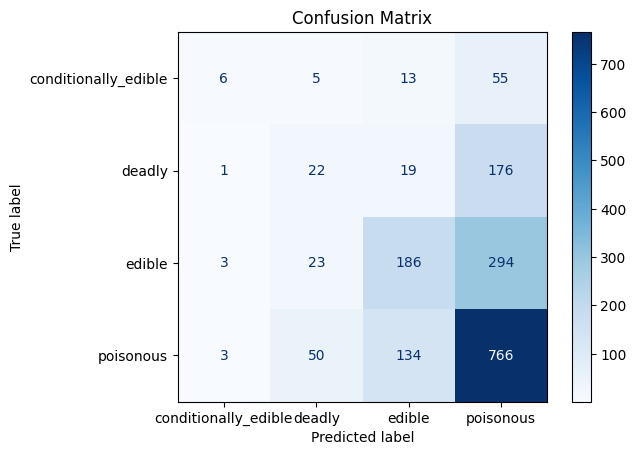

ft_last_30_flip_minimal done | Val Acc: 0.5165 | Val Loss: 1.6171 | Epochs Run: 18

Running: ft_last_30_flip_simple_lr_1e-4 (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 109s 423ms/step - accuracy: 0.6637 - loss: 0.8861 - val_accuracy: 0.5182 - val_loss: 1.3866
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 394ms/step - accuracy: 0.7781 - loss: 0.5847 - val_accuracy: 0.5046 - val_loss: 1.5354
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 96s 435ms/step - accuracy: 0.8227 - loss: 0.4773 - val_accuracy: 0.5103 - val_loss: 1.7959
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 99s 449ms/step - accuracy: 0.8539 - loss: 0.3959 - val_accuracy: 0.5427 - val_loss: 1.9750
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 99s 449ms/step - accuracy: 0.8856 - loss: 0.3174 - val_accuracy: 0.5456 - val_loss: 2.2143
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 99s 451ms/step - accuracy: 0.8974 - loss: 0.2889 - val_accuracy: 0.5473 - val_loss: 2.3478
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 96s 438ms/step - accuracy: 0.9095 - loss: 0.2658 - val_accuracy: 0.5421 - val_loss: 2.9060
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 98s 444ms/step - accuracy: 0.9250 - loss: 0.21

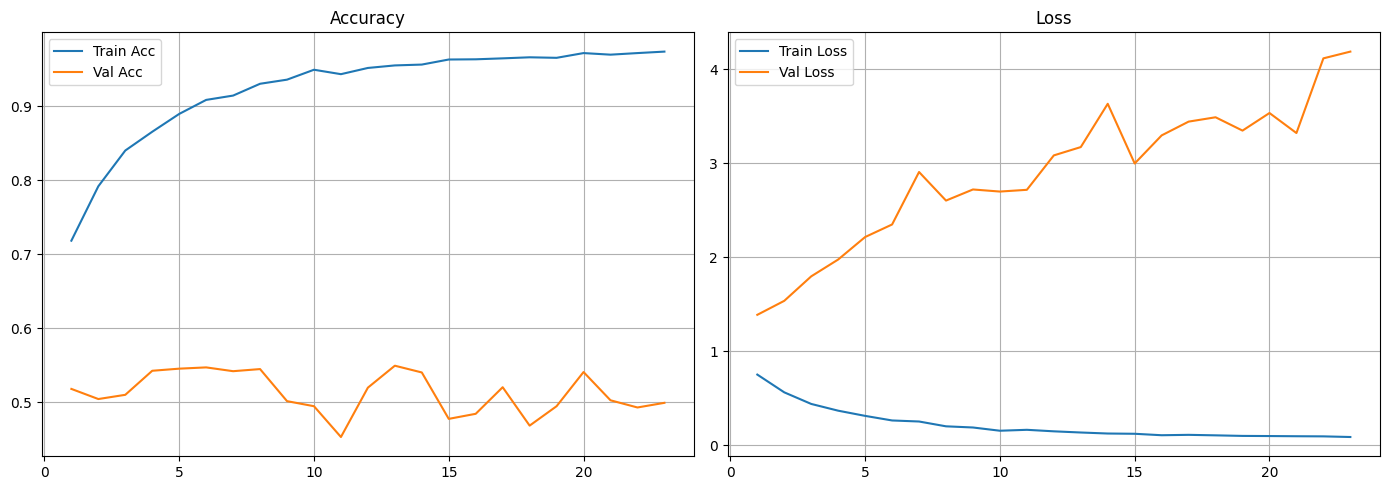

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

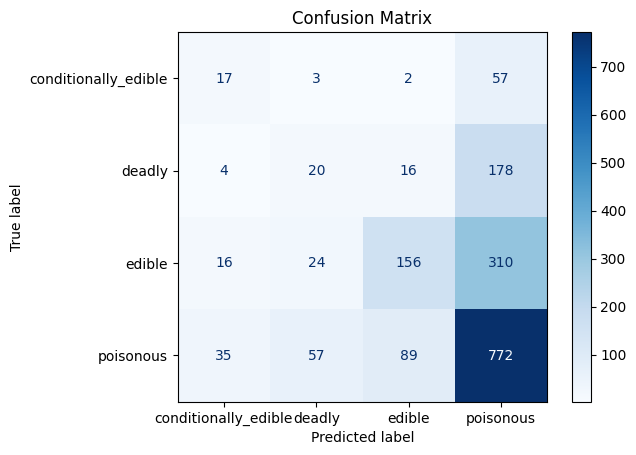

ft_last_30_flip_simple_lr_1e-4 done | Val Acc: 0.4994 | Val Loss: 4.1871 | Epochs Run: 23

Running: ft_last_30_flip_simple_lr_1e-6 (fine-tuned)
Epoch 1/200


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


220/220 ━━━━━━━━━━━━━━━━━━━━ 126s 476ms/step - accuracy: 0.4321 - loss: 1.3074 - val_accuracy: 0.4584 - val_loss: 1.2869
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 90s 411ms/step - accuracy: 0.5580 - loss: 1.0919 - val_accuracy: 0.5114 - val_loss: 1.2239
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 91s 413ms/step - accuracy: 0.6167 - loss: 0.9627 - val_accuracy: 0.5347 - val_loss: 1.1914
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.6646 - loss: 0.8524 - val_accuracy: 0.5427 - val_loss: 1.1777
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 587s 3s/step - accuracy: 0.7153 - loss: 0.7671 - val_accuracy: 0.5513 - val_loss: 1.1765
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1089s 5s/step - accuracy: 0.7538 - loss: 0.6781 - val_accuracy: 0.5547 - val_loss: 1.1818
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 169ms/step - accuracy: 0.7731 - loss: 0.6349 - val_accuracy: 0.5507 - val_loss: 1.1916
Epoch 8/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.7947 - loss: 0.5867 - va

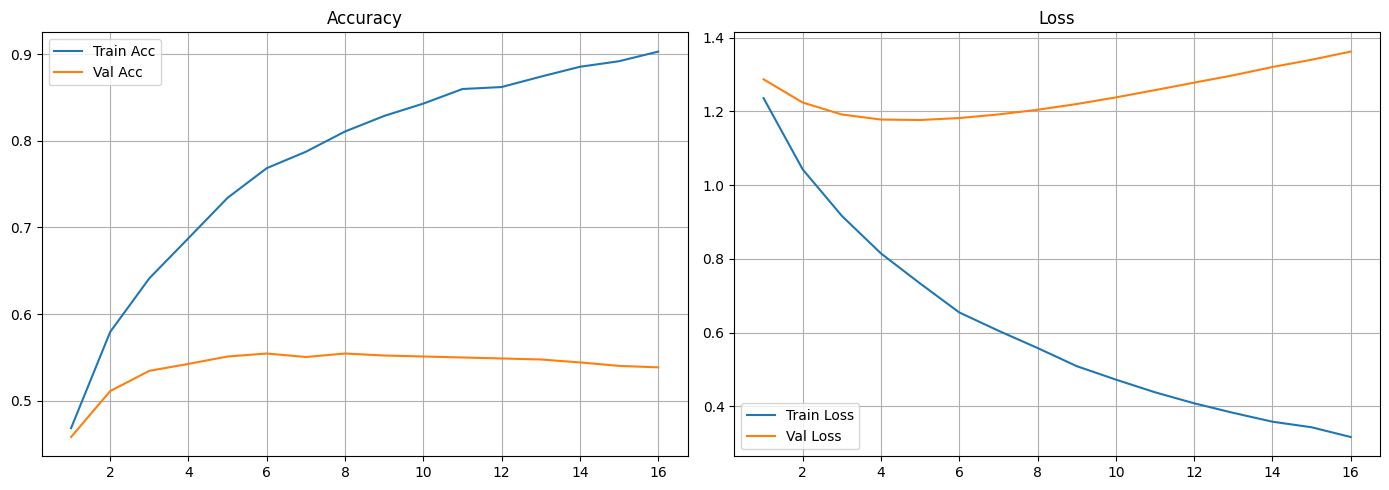

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

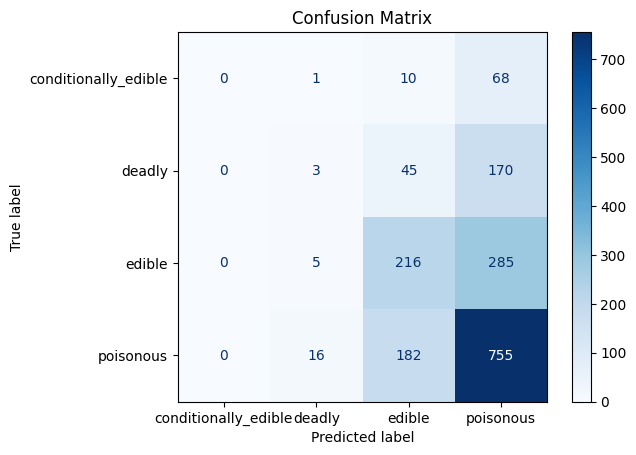

ft_last_30_flip_simple_lr_1e-6 done | Val Acc: 0.5387 | Val Loss: 1.3621 | Epochs Run: 16


In [20]:
results = []

for exp in experiments:
    result = run_experiment(
        name=exp["name"],
        fine_tune=exp["fine_tune"],
        fine_tune_at=exp.get("fine_tune_at", -30),
        learning_rate=exp["learning_rate"],
        augmentation_name=exp["augmentation_name"],
        classifier_name=exp["classifier_name"]
    )
    results.append(result)


In [21]:
df_results = pd.DataFrame(results)[[
    "name", "fine_tune", "fine_tune_at", "learning_rate",
    "epochs_ran", "augmentation", "classifier", "val_accuracy", "val_loss"
]]
df_results = df_results.sort_values("val_accuracy", ascending=False)
df_results


,name,fine_tune,fine_tune_at,learning_rate,epochs_ran,augmentation,classifier,val_accuracy,val_loss
5,ft_last_30_flip_zoom_simple,True,-30.0,0.000010,20,flip_zoom,simple,0.571754,1.192950
6,ft_last_30_flip_rotate_simple,True,-30.0,0.000010,32,flip_rotate,simple,0.568907,1.119786
0,ft_last_0_flip_simple,False,NaN,0.001000,36,flip,simple,0.562642,1.042190
2,ft_last_50_flip_simple,True,-50.0,0.000010,24,flip,simple,0.556378,1.256215
7,ft_last_30_flip_deep,True,-30.0,0.000010,15,flip,deep,0.553531,1.547019
1,ft_last_30_flip_simple,True,-30.0,0.000010,23,flip,simple,0.544989,1.186092
3,ft_last_80_flip_simple,True,-80.0,0.000010,16,flip,simple,0.541572,1.270857
10,ft_last_30_flip_simple_lr_1e-6,True,-30.0,0.000001,16,flip,simple,0.538724,1.362064
4,ft_all_layers_flip_simple,True,0.0,0.000010,23,flip,simple,0.529613,1.515287
8,ft_last_30_flip_minimal,True,-30.0,0.000010,18,flip,minimal,0.516515,1.617137
